In [2]:
# Treinamento de Modelos de Machine Learning - Diabetes
# Objetivo: Treinar diferentes algoritmos, validação cruzada e otimização de hiperparâmetros

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import time
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report, roc_curve, auc)
from sklearn.preprocessing import StandardScaler

# Algoritmos de ML
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost não disponível. Instale com: pip install xgboost")

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Bibliotecas importadas com sucesso!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {pd.__version__}")
if XGBOOST_AVAILABLE:
    print(f"XGBoost version: {xgb.__version__}")


Bibliotecas importadas com sucesso!
Pandas version: 2.3.2
NumPy version: 2.3.3
Scikit-learn version: 2.3.2
XGBoost version: 3.0.5


In [4]:
# Classes customizadas necessárias para carregar o pipeline
class OutlierTreatment:
    """Classe customizada para tratamento de outliers"""
    
    def __init__(self, outlier_vars, method='iqr', factor=1.5):
        self.outlier_vars = outlier_vars
        self.method = method
        self.factor = factor
        self.bounds_ = {}
    
    def fit(self, X, y=None):
        for var in self.outlier_vars:
            if var in X.columns:
                if self.method == 'iqr':
                    Q1 = X[var].quantile(0.25)
                    Q3 = X[var].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - self.factor * IQR
                    upper_bound = Q3 + self.factor * IQR
                elif self.method == 'zscore':
                    mean = X[var].mean()
                    std = X[var].std()
                    lower_bound = mean - self.factor * std
                    upper_bound = mean + self.factor * std
                
                self.bounds_[var] = (lower_bound, upper_bound)
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for var, (lower, upper) in self.bounds_.items():
            if var in X_transformed.columns:
                X_transformed[var] = np.where(X_transformed[var] < lower, lower, X_transformed[var])
                X_transformed[var] = np.where(X_transformed[var] > upper, upper, X_transformed[var])
        return X_transformed

class CategoricalEncoder:
    """Classe customizada para encoding de variáveis categóricas"""
    
    def __init__(self, onehot_vars, label_vars):
        self.onehot_vars = onehot_vars
        self.label_vars = label_vars
        self.label_encoders_ = {}
        self.onehot_categories_ = {}
    
    def fit(self, X, y=None):
        # Fit label encoders
        for var in self.label_vars:
            if var in X.columns:
                le = LabelEncoder()
                le.fit(X[var])
                self.label_encoders_[var] = le
        
        # Store onehot categories
        for var in self.onehot_vars:
            if var in X.columns:
                self.onehot_categories_[var] = X[var].unique()
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        
        # Apply label encoding
        for var, le in self.label_encoders_.items():
            if var in X_transformed.columns:
                X_transformed[var] = le.transform(X_transformed[var])
        
        # Apply onehot encoding
        for var in self.onehot_vars:
            if var in X_transformed.columns:
                dummies = pd.get_dummies(X_transformed[var], prefix=var, drop_first=True)
                X_transformed = X_transformed.drop(columns=[var])
                X_transformed = pd.concat([X_transformed, dummies], axis=1)
        
        return X_transformed

# Carregamento dos dados processados
print("="*60)
print("CARREGAMENTO DOS DADOS PROCESSADOS")
print("="*60)

# Carregar dados processados
X_train = pd.read_csv('../data/processed/X_train_processed.csv', index_col=0)
X_test = pd.read_csv('../data/processed/X_test_processed.csv', index_col=0)
y_train = pd.read_csv('../data/processed/y_train.csv', index_col=0).squeeze()
y_test = pd.read_csv('../data/processed/y_test.csv', index_col=0).squeeze()

print(f"Shape dos dados:")
print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

# Verificar tipos de dados
print(f"\nTipos de dados:")
print(f"X_train: {X_train.dtypes.value_counts()}")
print(f"y_train: {y_train.dtype}")

# Verificar distribuição das classes
print(f"\nDistribuição das classes:")
print(f"Train: {y_train.value_counts(normalize=True).round(3)}")
print(f"Test:  {y_test.value_counts(normalize=True).round(3)}")

# Verificar se há valores nulos
print(f"\nValores nulos:")
print(f"X_train: {X_train.isnull().sum().sum()}")
print(f"X_test:  {X_test.isnull().sum().sum()}")
print(f"y_train: {y_train.isnull().sum()}")
print(f"y_test:  {y_test.isnull().sum()}")

# Carregar pipeline de transformação (para referência)
try:
    preprocessing_pipeline = joblib.load('../models/preprocessing_pipeline.pkl')
    transformation_info = joblib.load('../models/transformation_info.pkl')
    print(f"\n✅ Pipeline e informações de transformação carregados com sucesso!")
    print(f"Features disponíveis: {len(transformation_info['feature_names'])}")
except FileNotFoundError:
    print(f"\n⚠️ Pipeline não encontrado. Execute o notebook 02_preparacao_dados.ipynb primeiro!")
except Exception as e:
    print(f"\n⚠️ Erro ao carregar pipeline: {str(e)}")
    print("Continuando sem pipeline de referência...")

print(f"\n✅ Dados carregados e verificados com sucesso!")


CARREGAMENTO DOS DADOS PROCESSADOS
Shape dos dados:
X_train: (80000, 45)
X_test:  (20000, 45)
y_train: (80000,)
y_test:  (20000,)

Tipos de dados:
X_train: float64    45
Name: count, dtype: int64
y_train: int64

Distribuição das classes:
Train: diagnosed_diabetes
1    0.6
0    0.4
Name: proportion, dtype: float64
Test:  diagnosed_diabetes
1    0.6
0    0.4
Name: proportion, dtype: float64

Valores nulos:
X_train: 0
X_test:  0
y_train: 0
y_test:  0

✅ Pipeline e informações de transformação carregados com sucesso!
Features disponíveis: 45

✅ Dados carregados e verificados com sucesso!


In [5]:
# Definição dos algoritmos de ML para teste
print("="*60)
print("DEFINIÇÃO DOS ALGORITMOS DE ML")
print("="*60)

# Configuração da validação cruzada
cv_folds = 5
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(f"Estratégia de validação cruzada: {cv_folds} folds estratificados")
print(f"Random state: 42 (para reprodutibilidade)")

# Definir algoritmos baseline (com hiperparâmetros padrão)
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Neural Network': MLPClassifier(random_state=42, max_iter=1000)
}

# Adicionar XGBoost se disponível
if XGBOOST_AVAILABLE:
    baseline_models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

print(f"\nAlgoritmos definidos para teste ({len(baseline_models)}):")
for i, (name, model) in enumerate(baseline_models.items(), 1):
    print(f"  {i}. {name}: {type(model).__name__}")

# Definir grids de hiperparâmetros para otimização
hyperparameter_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    },
    
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.5, 1.0, 1.5]
    },
    
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'linear']
    },
    
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    
    'Decision Tree': {
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    
    'Neural Network': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
}

# Adicionar XGBoost se disponível
if XGBOOST_AVAILABLE:
    hyperparameter_grids['XGBoost'] = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

print(f"\nGrids de hiperparâmetros definidos para {len(hyperparameter_grids)} algoritmos")
print("Estratégia: GridSearchCV para algoritmos rápidos, RandomizedSearchCV para algoritmos complexos")

# Definir métricas de avaliação
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
print(f"\nMétricas de avaliação: {scoring_metrics}")

print(f"\n✅ Configuração dos algoritmos concluída!")


DEFINIÇÃO DOS ALGORITMOS DE ML
Estratégia de validação cruzada: 5 folds estratificados
Random state: 42 (para reprodutibilidade)

Algoritmos definidos para teste (10):
  1. Logistic Regression: LogisticRegression
  2. Random Forest: RandomForestClassifier
  3. Gradient Boosting: GradientBoostingClassifier
  4. AdaBoost: AdaBoostClassifier
  5. SVM: SVC
  6. K-Nearest Neighbors: KNeighborsClassifier
  7. Naive Bayes: GaussianNB
  8. Decision Tree: DecisionTreeClassifier
  9. Neural Network: MLPClassifier
  10. XGBoost: XGBClassifier

Grids de hiperparâmetros definidos para 9 algoritmos
Estratégia: GridSearchCV para algoritmos rápidos, RandomizedSearchCV para algoritmos complexos

Métricas de avaliação: ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

✅ Configuração dos algoritmos concluída!


In [6]:
# Treinamento dos modelos baseline com validação cruzada
print("="*60)
print("TREINAMENTO DOS MODELOS BASELINE")
print("="*60)

# Função para calcular métricas
def calculate_metrics(y_true, y_pred, y_pred_proba=None):
    """Calcula métricas de avaliação"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    return metrics

# Dicionário para armazenar resultados
baseline_results = {}
training_times = {}

print("Iniciando treinamento dos modelos baseline...")
print(f"Validação cruzada: {cv_folds} folds")
print("-" * 50)

for name, model in baseline_models.items():
    print(f"\nTreinando {name}...")
    start_time = time.time()
    
    try:
        # Validação cruzada
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='f1', n_jobs=-1)
        
        # Treinar modelo no conjunto completo de treino
        model.fit(X_train, y_train)
        
        # Fazer predições no conjunto de teste
        y_pred = model.predict(X_test)
        
        # Calcular probabilidades (se disponível)
        try:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        except:
            y_pred_proba = None
        
        # Calcular métricas
        metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
        
        # Armazenar resultados
        baseline_results[name] = {
            'model': model,
            'cv_scores': cv_scores,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'test_metrics': metrics,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
        
        training_time = time.time() - start_time
        training_times[name] = training_time
        
        print(f"  ✅ Concluído em {training_time:.2f}s")
        print(f"  CV F1-Score: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
        print(f"  Test F1-Score: {metrics['f1']:.3f}")
        
    except Exception as e:
        print(f"  ❌ Erro: {str(e)}")
        baseline_results[name] = {'error': str(e)}
        training_times[name] = 0

print(f"\n✅ Treinamento dos modelos baseline concluído!")
print(f"Modelos treinados com sucesso: {len([r for r in baseline_results.values() if 'error' not in r])}")


TREINAMENTO DOS MODELOS BASELINE
Iniciando treinamento dos modelos baseline...
Validação cruzada: 5 folds
--------------------------------------------------

Treinando Logistic Regression...
  ✅ Concluído em 1.25s
  CV F1-Score: 0.999 (±0.000)
  Test F1-Score: 0.999

Treinando Random Forest...
  ✅ Concluído em 4.02s
  CV F1-Score: 1.000 (±0.000)
  Test F1-Score: 1.000

Treinando Gradient Boosting...
  ✅ Concluído em 30.71s
  CV F1-Score: 1.000 (±0.000)
  Test F1-Score: 1.000

Treinando AdaBoost...
  ✅ Concluído em 6.96s
  CV F1-Score: 1.000 (±0.000)
  Test F1-Score: 1.000

Treinando SVM...
  ✅ Concluído em 142.63s
  CV F1-Score: 0.999 (±0.000)
  Test F1-Score: 0.999

Treinando K-Nearest Neighbors...
  ✅ Concluído em 10.20s
  CV F1-Score: 0.998 (±0.000)
  Test F1-Score: 0.999

Treinando Naive Bayes...
  ✅ Concluído em 0.27s
  CV F1-Score: 0.998 (±0.000)
  Test F1-Score: 0.998

Treinando Decision Tree...
  ✅ Concluído em 0.53s
  CV F1-Score: 0.999 (±0.000)
  Test F1-Score: 1.000

Treinan

RESULTADOS DOS MODELOS BASELINE
Ranking dos modelos por F1-Score no conjunto de teste:
------------------------------------------------------------
                 Model  CV_F1_Mean  CV_F1_Std  Test_Accuracy  Test_Precision  \
2    Gradient Boosting       1.000        0.0          1.000           1.000   
1        Random Forest       1.000        0.0          1.000           1.000   
3             AdaBoost       1.000        0.0          1.000           1.000   
7        Decision Tree       0.999        0.0          1.000           1.000   
9              XGBoost       1.000        0.0          0.999           1.000   
4                  SVM       0.999        0.0          0.999           0.999   
8       Neural Network       0.999        0.0          0.999           0.999   
0  Logistic Regression       0.999        0.0          0.999           0.999   
5  K-Nearest Neighbors       0.998        0.0          0.998           0.999   
6          Naive Bayes       0.998        0.0       

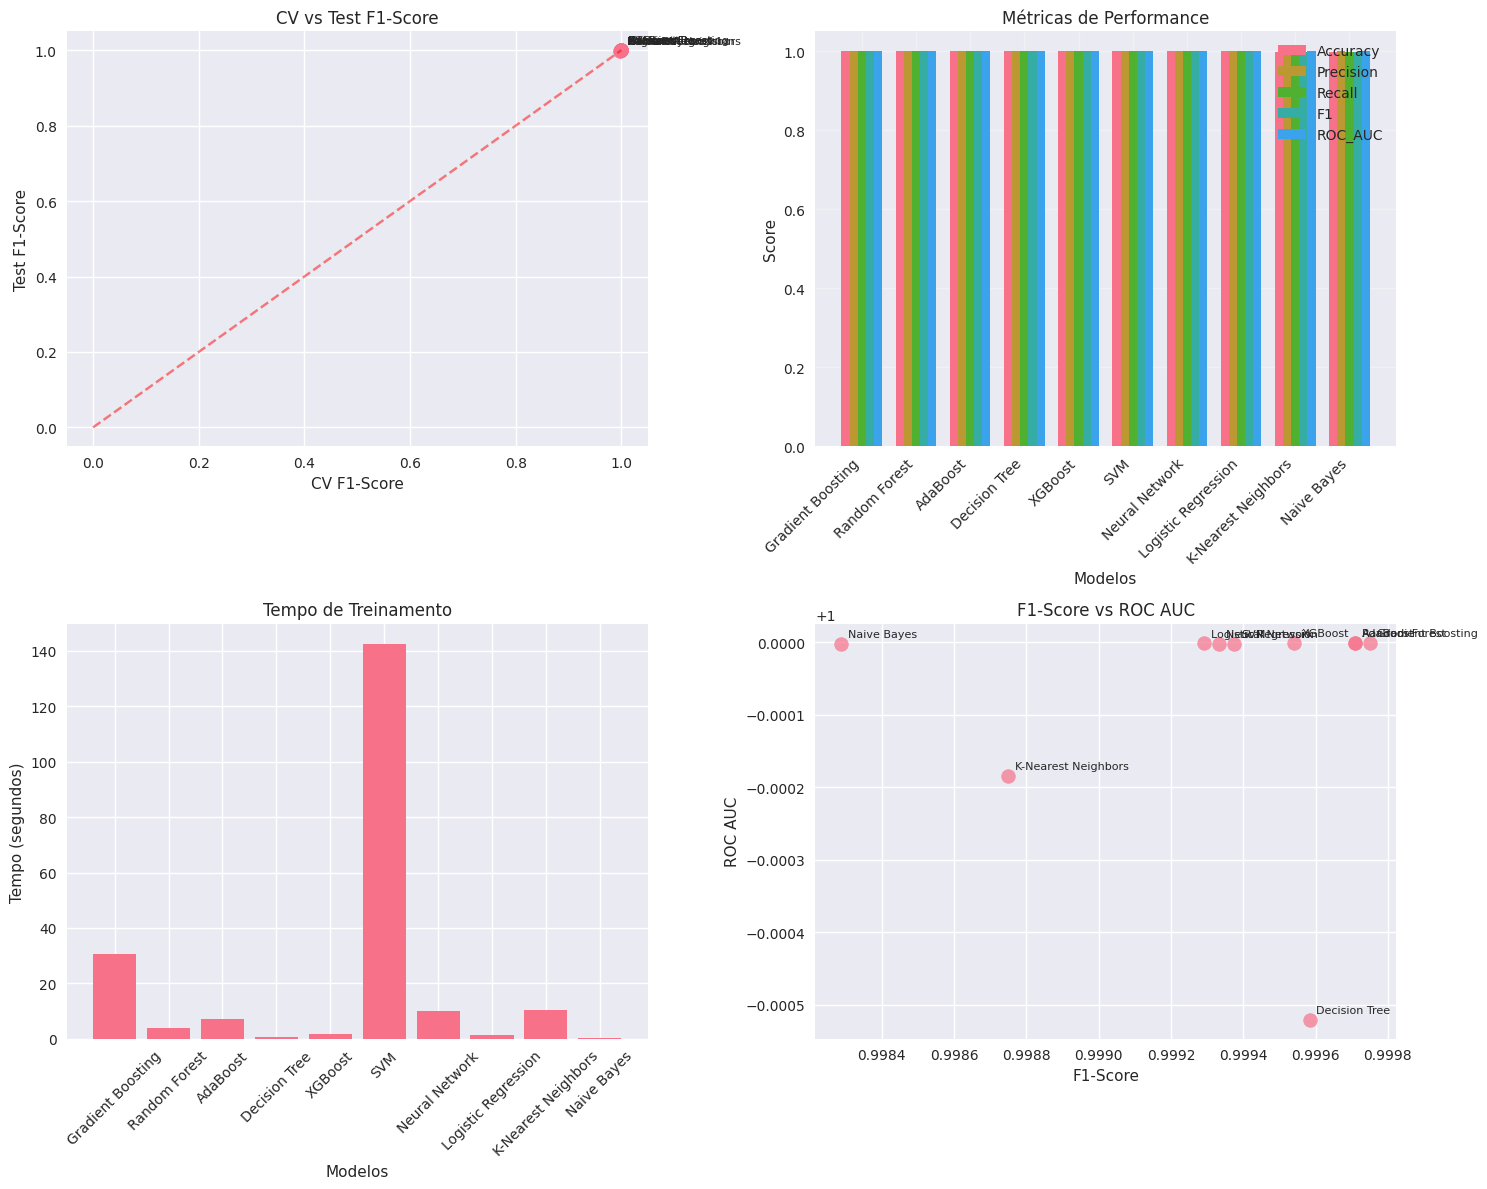


🏆 MELHORES MODELOS:
Melhor F1-Score: Gradient Boosting (1.000)
Melhor ROC AUC: AdaBoost (1.000)

✅ Análise dos modelos baseline concluída!


In [7]:
# Visualização dos resultados baseline
print("="*60)
print("RESULTADOS DOS MODELOS BASELINE")
print("="*60)

# Criar DataFrame com resultados
results_data = []
for name, result in baseline_results.items():
    if 'error' not in result:
        results_data.append({
            'Model': name,
            'CV_F1_Mean': result['cv_mean'],
            'CV_F1_Std': result['cv_std'],
            'Test_Accuracy': result['test_metrics']['accuracy'],
            'Test_Precision': result['test_metrics']['precision'],
            'Test_Recall': result['test_metrics']['recall'],
            'Test_F1': result['test_metrics']['f1'],
            'Test_ROC_AUC': result['test_metrics'].get('roc_auc', np.nan),
            'Training_Time': training_times[name]
        })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Test_F1', ascending=False)

print("Ranking dos modelos por F1-Score no conjunto de teste:")
print("-" * 60)
print(results_df.round(3))

# Visualizações
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. F1-Score: CV vs Test
axes[0, 0].scatter(results_df['CV_F1_Mean'], results_df['Test_F1'], s=100, alpha=0.7)
axes[0, 0].plot([0, 1], [0, 1], 'r--', alpha=0.5)
axes[0, 0].set_xlabel('CV F1-Score')
axes[0, 0].set_ylabel('Test F1-Score')
axes[0, 0].set_title('CV vs Test F1-Score')
for i, model in enumerate(results_df['Model']):
    axes[0, 0].annotate(model, (results_df.iloc[i]['CV_F1_Mean'], results_df.iloc[i]['Test_F1']), 
                       xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2. Métricas principais
metrics_to_plot = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC']
x_pos = np.arange(len(results_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    if metric in results_df.columns:
        axes[0, 1].bar(x_pos + i*width, results_df[metric], width, label=metric.replace('Test_', ''))

axes[0, 1].set_xlabel('Modelos')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Métricas de Performance')
axes[0, 1].set_xticks(x_pos + width * 2)
axes[0, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Tempo de treinamento
axes[1, 0].bar(results_df['Model'], results_df['Training_Time'])
axes[1, 0].set_xlabel('Modelos')
axes[1, 0].set_ylabel('Tempo (segundos)')
axes[1, 0].set_title('Tempo de Treinamento')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. ROC AUC vs F1-Score
valid_roc = results_df.dropna(subset=['Test_ROC_AUC'])
if len(valid_roc) > 0:
    axes[1, 1].scatter(valid_roc['Test_F1'], valid_roc['Test_ROC_AUC'], s=100, alpha=0.7)
    axes[1, 1].set_xlabel('F1-Score')
    axes[1, 1].set_ylabel('ROC AUC')
    axes[1, 1].set_title('F1-Score vs ROC AUC')
    for i, model in enumerate(valid_roc['Model']):
        axes[1, 1].annotate(model, (valid_roc.iloc[i]['Test_F1'], valid_roc.iloc[i]['Test_ROC_AUC']), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Identificar melhores modelos
best_f1_model = results_df.iloc[0]['Model']
best_auc_model = results_df.loc[results_df['Test_ROC_AUC'].idxmax(), 'Model'] if 'Test_ROC_AUC' in results_df.columns else None

print(f"\n🏆 MELHORES MODELOS:")
print(f"Melhor F1-Score: {best_f1_model} ({results_df.iloc[0]['Test_F1']:.3f})")
if best_auc_model:
    print(f"Melhor ROC AUC: {best_auc_model} ({results_df.loc[results_df['Test_ROC_AUC'].idxmax(), 'Test_ROC_AUC']:.3f})")

print(f"\n✅ Análise dos modelos baseline concluída!")


In [8]:
# Otimização de hiperparâmetros
print("="*60)
print("OTIMIZAÇÃO DE HIPERPARÂMETROS")
print("="*60)

# Selecionar os melhores modelos para otimização (top 3 por F1-Score)
top_models = results_df.head(3)['Model'].tolist()
print(f"Modelos selecionados para otimização: {top_models}")

# Dicionário para armazenar resultados da otimização
optimized_results = {}
optimization_times = {}

print(f"\nIniciando otimização de hiperparâmetros...")
print(f"Estratégia: GridSearchCV para algoritmos rápidos, RandomizedSearchCV para algoritmos complexos")
print("-" * 60)

for model_name in top_models:
    if model_name in hyperparameter_grids:
        print(f"\nOtimizando {model_name}...")
        start_time = time.time()
        
        try:
            # Obter modelo baseline
            baseline_model = baseline_models[model_name]
            param_grid = hyperparameter_grids[model_name]
            
            # Decidir entre GridSearchCV e RandomizedSearchCV
            total_combinations = 1
            for param, values in param_grid.items():
                total_combinations *= len(values)
            
            print(f"  Total de combinações: {total_combinations}")
            
            if total_combinations <= 50:  # GridSearchCV para poucas combinações
                search = GridSearchCV(
                    baseline_model, 
                    param_grid, 
                    cv=cv_strategy, 
                    scoring='f1', 
                    n_jobs=-1, 
                    verbose=0
                )
                search_type = "GridSearchCV"
            else:  # RandomizedSearchCV para muitas combinações
                search = RandomizedSearchCV(
                    baseline_model, 
                    param_grid, 
                    n_iter=50,  # Limitar a 50 iterações
                    cv=cv_strategy, 
                    scoring='f1', 
                    n_jobs=-1, 
                    random_state=42,
                    verbose=0
                )
                search_type = "RandomizedSearchCV"
            
            print(f"  Usando: {search_type}")
            
            # Executar busca
            search.fit(X_train, y_train)
            
            # Fazer predições com o melhor modelo
            best_model = search.best_estimator_
            y_pred = best_model.predict(X_test)
            
            # Calcular probabilidades
            try:
                y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            except:
                y_pred_proba = None
            
            # Calcular métricas
            metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
            
            # Armazenar resultados
            optimized_results[model_name] = {
                'best_model': best_model,
                'best_params': search.best_params_,
                'best_cv_score': search.best_score_,
                'test_metrics': metrics,
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'search_type': search_type,
                'total_combinations': total_combinations
            }
            
            optimization_time = time.time() - start_time
            optimization_times[model_name] = optimization_time
            
            print(f"  ✅ Concluído em {optimization_time:.2f}s")
            print(f"  Melhor CV Score: {search.best_score_:.3f}")
            print(f"  Test F1-Score: {metrics['f1']:.3f}")
            print(f"  Melhores parâmetros: {search.best_params_}")
            
        except Exception as e:
            print(f"  ❌ Erro: {str(e)}")
            optimized_results[model_name] = {'error': str(e)}
            optimization_times[model_name] = 0

print(f"\n✅ Otimização de hiperparâmetros concluída!")
print(f"Modelos otimizados com sucesso: {len([r for r in optimized_results.values() if 'error' not in r])}")


OTIMIZAÇÃO DE HIPERPARÂMETROS
Modelos selecionados para otimização: ['Gradient Boosting', 'Random Forest', 'AdaBoost']

Iniciando otimização de hiperparâmetros...
Estratégia: GridSearchCV para algoritmos rápidos, RandomizedSearchCV para algoritmos complexos
------------------------------------------------------------

Otimizando Gradient Boosting...
  Total de combinações: 54
  Usando: RandomizedSearchCV
  ✅ Concluído em 1209.72s
  Melhor CV Score: 1.000
  Test F1-Score: 1.000
  Melhores parâmetros: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}

Otimizando Random Forest...
  Total de combinações: 81
  Usando: RandomizedSearchCV
  ✅ Concluído em 277.24s
  Melhor CV Score: 1.000
  Test F1-Score: 1.000
  Melhores parâmetros: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}

Otimizando AdaBoost...
  Total de combinações: 9
  Usando: GridSearchCV
  ✅ Concluído em 64.02s
  Melhor CV Score: 1.000
  Test F1-Score: 1.000
  Me

COMPARAÇÃO FINAL: BASELINE vs OTIMIZADO
Ranking final de todos os modelos:
------------------------------------------------------------
                  Model       Type  F1_Score  ROC_AUC  Accuracy  Precision  \
2     Gradient Boosting   Baseline     1.000    1.000     1.000      1.000   
10    Gradient Boosting  Otimizado     1.000    1.000     1.000      1.000   
11        Random Forest  Otimizado     1.000    1.000     1.000      1.000   
1         Random Forest   Baseline     1.000    1.000     1.000      1.000   
3              AdaBoost   Baseline     1.000    1.000     1.000      1.000   
12             AdaBoost  Otimizado     1.000    1.000     1.000      1.000   
7         Decision Tree   Baseline     1.000    0.999     1.000      1.000   
9               XGBoost   Baseline     1.000    1.000     0.999      1.000   
4                   SVM   Baseline     0.999    1.000     0.999      0.999   
8        Neural Network   Baseline     0.999    1.000     0.999      0.999   
0   Lo

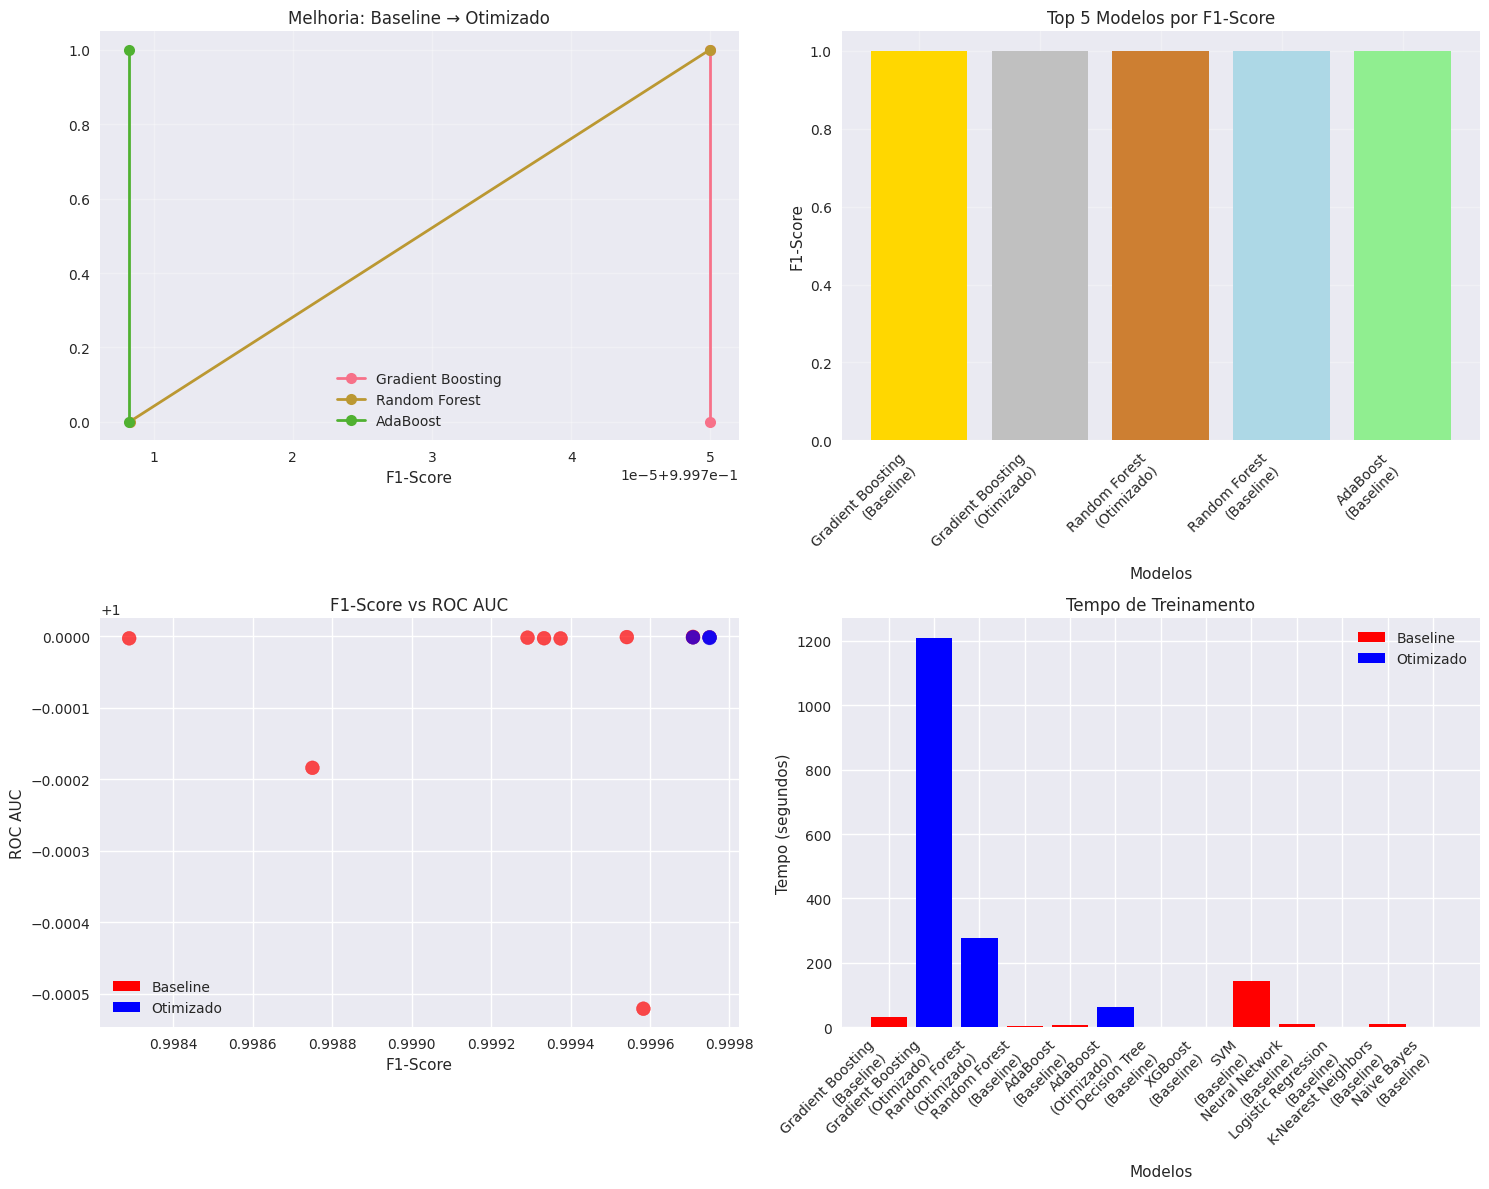


🏆 MELHOR MODELO GERAL:
Nome: Gradient Boosting (Baseline)
F1-Score: 1.000
ROC AUC: 1.000
Accuracy: 1.000

📈 ANÁLISE DE MELHORIA:
Gradient Boosting: 1.000 → 1.000 (+0.000, +0.0%)
Random Forest: 1.000 → 1.000 (+0.000, +0.0%)
AdaBoost: 1.000 → 1.000 (+0.000, +0.0%)

✅ Comparação final concluída!


In [9]:
# Comparação final: Baseline vs Otimizado
print("="*60)
print("COMPARAÇÃO FINAL: BASELINE vs OTIMIZADO")
print("="*60)

# Criar DataFrame de comparação
comparison_data = []

# Adicionar resultados baseline
for name, result in baseline_results.items():
    if 'error' not in result:
        comparison_data.append({
            'Model': name,
            'Type': 'Baseline',
            'F1_Score': result['test_metrics']['f1'],
            'ROC_AUC': result['test_metrics'].get('roc_auc', np.nan),
            'Accuracy': result['test_metrics']['accuracy'],
            'Precision': result['test_metrics']['precision'],
            'Recall': result['test_metrics']['recall'],
            'Training_Time': training_times[name]
        })

# Adicionar resultados otimizados
for name, result in optimized_results.items():
    if 'error' not in result:
        comparison_data.append({
            'Model': name,
            'Type': 'Otimizado',
            'F1_Score': result['test_metrics']['f1'],
            'ROC_AUC': result['test_metrics'].get('roc_auc', np.nan),
            'Accuracy': result['test_metrics']['accuracy'],
            'Precision': result['test_metrics']['precision'],
            'Recall': result['test_metrics']['recall'],
            'Training_Time': optimization_times[name]
        })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1_Score', ascending=False)

print("Ranking final de todos os modelos:")
print("-" * 60)
print(comparison_df.round(3))

# Visualizações de comparação
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. F1-Score: Baseline vs Otimizado
baseline_data = comparison_df[comparison_df['Type'] == 'Baseline']
optimized_data = comparison_df[comparison_df['Type'] == 'Otimizado']

if len(baseline_data) > 0 and len(optimized_data) > 0:
    # Encontrar modelos que foram otimizados
    optimized_models = optimized_data['Model'].unique()
    
    for model in optimized_models:
        baseline_f1 = baseline_data[baseline_data['Model'] == model]['F1_Score'].iloc[0]
        optimized_f1 = optimized_data[optimized_data['Model'] == model]['F1_Score'].iloc[0]
        
        axes[0, 0].plot([baseline_f1, optimized_f1], [0, 1], 'o-', label=model, linewidth=2, markersize=8)
    
    axes[0, 0].set_xlabel('F1-Score')
    axes[0, 0].set_ylabel('')
    axes[0, 0].set_title('Melhoria: Baseline → Otimizado')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

# 2. Top 5 modelos por F1-Score
top_5 = comparison_df.head(5)
x_pos = np.arange(len(top_5))
axes[0, 1].bar(x_pos, top_5['F1_Score'], color=['gold', 'silver', '#CD7F32', 'lightblue', 'lightgreen'])
axes[0, 1].set_xlabel('Modelos')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_title('Top 5 Modelos por F1-Score')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([f"{row['Model']}\n({row['Type']})" for _, row in top_5.iterrows()], rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# 3. ROC AUC vs F1-Score
valid_data = comparison_df.dropna(subset=['ROC_AUC'])
if len(valid_data) > 0:
    colors = ['red' if t == 'Baseline' else 'blue' for t in valid_data['Type']]
    axes[1, 0].scatter(valid_data['F1_Score'], valid_data['ROC_AUC'], c=colors, s=100, alpha=0.7)
    axes[1, 0].set_xlabel('F1-Score')
    axes[1, 0].set_ylabel('ROC AUC')
    axes[1, 0].set_title('F1-Score vs ROC AUC')
    
    # Adicionar legenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', label='Baseline'),
                      Patch(facecolor='blue', label='Otimizado')]
    axes[1, 0].legend(handles=legend_elements)

# 4. Tempo de treinamento
axes[1, 1].bar(range(len(comparison_df)), comparison_df['Training_Time'], 
               color=['red' if t == 'Baseline' else 'blue' for t in comparison_df['Type']])
axes[1, 1].set_xlabel('Modelos')
axes[1, 1].set_ylabel('Tempo (segundos)')
axes[1, 1].set_title('Tempo de Treinamento')
axes[1, 1].set_xticks(range(len(comparison_df)))
axes[1, 1].set_xticklabels([f"{row['Model']}\n({row['Type']})" for _, row in comparison_df.iterrows()], 
                           rotation=45, ha='right')
axes[1, 1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# Identificar o melhor modelo geral
best_model_overall = comparison_df.iloc[0]
print(f"\n🏆 MELHOR MODELO GERAL:")
print(f"Nome: {best_model_overall['Model']} ({best_model_overall['Type']})")
print(f"F1-Score: {best_model_overall['F1_Score']:.3f}")
print(f"ROC AUC: {best_model_overall['ROC_AUC']:.3f}")
print(f"Accuracy: {best_model_overall['Accuracy']:.3f}")

# Análise de melhoria
print(f"\n📈 ANÁLISE DE MELHORIA:")
for model in optimized_models:
    baseline_f1 = baseline_data[baseline_data['Model'] == model]['F1_Score'].iloc[0]
    optimized_f1 = optimized_data[optimized_data['Model'] == model]['F1_Score'].iloc[0]
    improvement = optimized_f1 - baseline_f1
    improvement_pct = (improvement / baseline_f1) * 100
    
    print(f"{model}: {baseline_f1:.3f} → {optimized_f1:.3f} ({improvement:+.3f}, {improvement_pct:+.1f}%)")

print(f"\n✅ Comparação final concluída!")


In [10]:
# Salvar melhores modelos
print("="*60)
print("SALVANDO MELHORES MODELOS")
print("="*60)

# Criar diretório para modelos se não existir
import os
os.makedirs('../models', exist_ok=True)

# Salvar o melhor modelo geral
best_model_name = best_model_overall['Model']
best_model_type = best_model_overall['Type']

if best_model_type == 'Otimizado':
    best_model = optimized_results[best_model_name]['best_model']
    best_params = optimized_results[best_model_name]['best_params']
else:
    best_model = baseline_results[best_model_name]['model']
    best_params = "Parâmetros padrão"

# Salvar modelo
model_filename = f"../models/best_model_{best_model_name.lower().replace(' ', '_')}.pkl"
joblib.dump(best_model, model_filename)
print(f"✅ Melhor modelo salvo: {model_filename}")

# Salvar todos os modelos otimizados
print(f"\nSalvando modelos otimizados...")
for name, result in optimized_results.items():
    if 'error' not in result:
        model_filename = f"../models/optimized_{name.lower().replace(' ', '_')}.pkl"
        joblib.dump(result['best_model'], model_filename)
        print(f"  ✅ {name}: {model_filename}")

# Salvar resultados de treinamento
training_results = {
    'baseline_results': baseline_results,
    'optimized_results': optimized_results,
    'comparison_df': comparison_df,
    'best_model_info': {
        'name': best_model_name,
        'type': best_model_type,
        'f1_score': best_model_overall['F1_Score'],
        'roc_auc': best_model_overall['ROC_AUC'],
        'accuracy': best_model_overall['Accuracy'],
        'best_params': best_params
    },
    'training_times': training_times,
    'optimization_times': optimization_times,
    'timestamp': datetime.now().isoformat()
}

results_filename = "../models/training_results.pkl"
joblib.dump(training_results, results_filename)
print(f"\n✅ Resultados de treinamento salvos: {results_filename}")

# Salvar DataFrame de comparação como CSV
comparison_df.to_csv("../models/model_comparison.csv", index=False)
print(f"✅ Comparação de modelos salva: ../models/model_comparison.csv")

# Criar relatório de treinamento
report_filename = "../models/training_report.txt"
with open(report_filename, 'w', encoding='utf-8') as f:
    f.write("RELATÓRIO DE TREINAMENTO DE MODELOS - DIABETES\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Data: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Dataset: {X_train.shape[0]} amostras de treino, {X_test.shape[0]} amostras de teste\n")
    f.write(f"Features: {X_train.shape[1]}\n")
    f.write(f"Validação cruzada: {cv_folds} folds estratificados\n\n")
    
    f.write("MELHOR MODELO:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Nome: {best_model_name} ({best_model_type})\n")
    f.write(f"F1-Score: {best_model_overall['F1_Score']:.3f}\n")
    f.write(f"ROC AUC: {best_model_overall['ROC_AUC']:.3f}\n")
    f.write(f"Accuracy: {best_model_overall['Accuracy']:.3f}\n")
    f.write(f"Precision: {best_model_overall['Precision']:.3f}\n")
    f.write(f"Recall: {best_model_overall['Recall']:.3f}\n")
    f.write(f"Parâmetros: {best_params}\n\n")
    
    f.write("TOP 5 MODELOS:\n")
    f.write("-" * 20 + "\n")
    for i, (_, row) in enumerate(comparison_df.head(5).iterrows(), 1):
        f.write(f"{i}. {row['Model']} ({row['Type']}): F1={row['F1_Score']:.3f}, AUC={row['ROC_AUC']:.3f}\n")
    
    f.write(f"\nMODELOS TREINADOS: {len(baseline_results)}\n")
    f.write(f"MODELOS OTIMIZADOS: {len(optimized_results)}\n")
    f.write(f"TEMPO TOTAL DE TREINAMENTO: {sum(training_times.values()):.2f}s\n")
    f.write(f"TEMPO TOTAL DE OTIMIZAÇÃO: {sum(optimization_times.values()):.2f}s\n")

print(f"✅ Relatório de treinamento salvo: {report_filename}")

print(f"\n📁 ARQUIVOS SALVOS:")
print(f"  • Melhor modelo: {model_filename}")
print(f"  • Modelos otimizados: ../models/optimized_*.pkl")
print(f"  • Resultados: {results_filename}")
print(f"  • Comparação: ../models/model_comparison.csv")
print(f"  • Relatório: {report_filename}")

print(f"\n✅ Salvamento de modelos concluído!")


SALVANDO MELHORES MODELOS
✅ Melhor modelo salvo: ../models/best_model_gradient_boosting.pkl

Salvando modelos otimizados...
  ✅ Gradient Boosting: ../models/optimized_gradient_boosting.pkl
  ✅ Random Forest: ../models/optimized_random_forest.pkl
  ✅ AdaBoost: ../models/optimized_adaboost.pkl

✅ Resultados de treinamento salvos: ../models/training_results.pkl
✅ Comparação de modelos salva: ../models/model_comparison.csv
✅ Relatório de treinamento salvo: ../models/training_report.txt

📁 ARQUIVOS SALVOS:
  • Melhor modelo: ../models/optimized_adaboost.pkl
  • Modelos otimizados: ../models/optimized_*.pkl
  • Resultados: ../models/training_results.pkl
  • Comparação: ../models/model_comparison.csv
  • Relatório: ../models/training_report.txt

✅ Salvamento de modelos concluído!


ANÁLISE DE IMPORTÂNCIA DAS FEATURES
Analisando importância das features...
----------------------------------------
✅ Logistic Regression: Importância calculada
✅ Random Forest: Importância calculada
✅ Gradient Boosting: Importância calculada
✅ AdaBoost: Importância calculada
✅ Decision Tree: Importância calculada
✅ XGBoost: Importância calculada
✅ Gradient Boosting (Otimizado): Importância calculada
✅ Random Forest (Otimizado): Importância calculada
✅ AdaBoost (Otimizado): Importância calculada

Modelos com análise de importância: 9


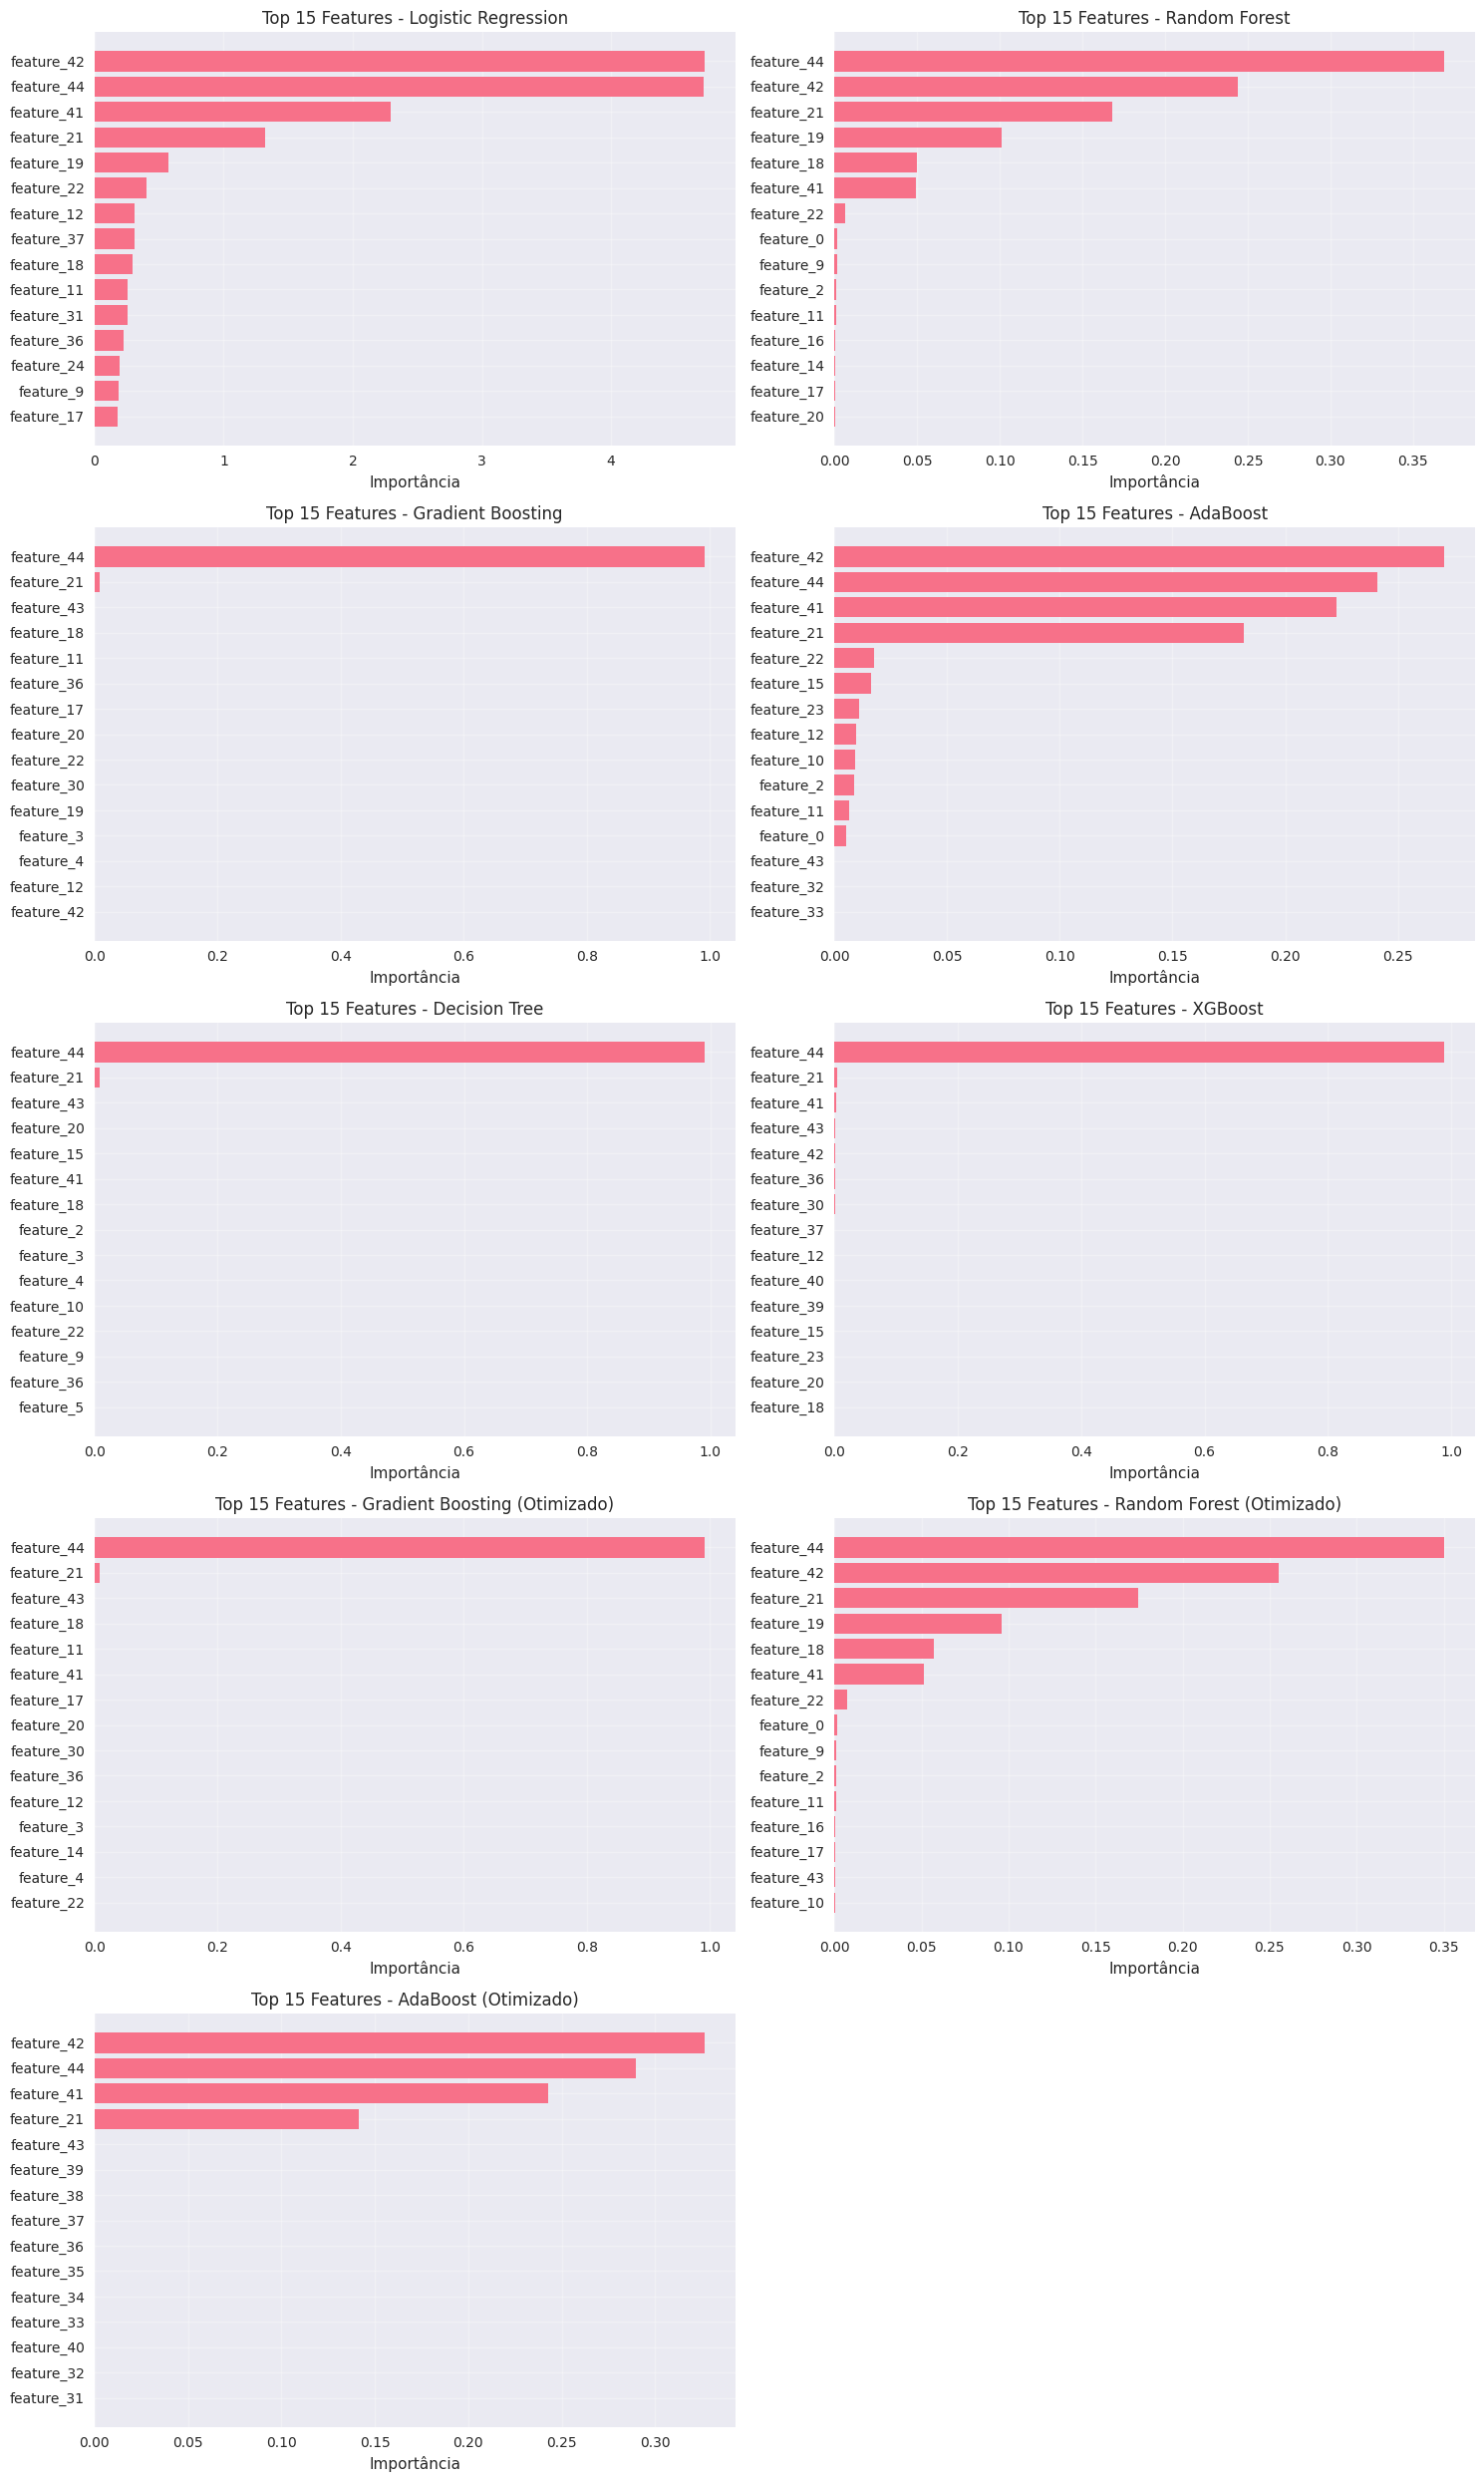


ANÁLISE DAS FEATURES MAIS IMPORTANTES:
--------------------------------------------------
Top 10 features mais importantes (média entre modelos):
 1. feature_44: 1.1035
 2. feature_42: 0.6467
 3. feature_41: 0.3179
 4. feature_21: 0.2239
 5. feature_19: 0.0858
 6. feature_22: 0.0478
 7. feature_18: 0.0447
 8. feature_12: 0.0359
 9. feature_37: 0.0346
10. feature_11: 0.0292

✅ Análise de importância salva: ../models/feature_importance.csv

✅ Análise de importância das features concluída!


In [11]:
# Análise de importância das features
print("="*60)
print("ANÁLISE DE IMPORTÂNCIA DAS FEATURES")
print("="*60)

# Função para obter importância das features
def get_feature_importance(model, feature_names):
    """Obtém importância das features de diferentes tipos de modelos"""
    try:
        if hasattr(model, 'feature_importances_'):
            # Tree-based models
            return model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Linear models
            return np.abs(model.coef_[0])
        else:
            return None
    except:
        return None

# Analisar importância das features para modelos que suportam
feature_importance_results = {}

print("Analisando importância das features...")
print("-" * 40)

for name, result in baseline_results.items():
    if 'error' not in result:
        model = result['model']
        importance = get_feature_importance(model, X_train.columns)
        
        if importance is not None:
            feature_importance_results[name] = {
                'importance': importance,
                'feature_names': X_train.columns.tolist()
            }
            print(f"✅ {name}: Importância calculada")

# Adicionar modelos otimizados
for name, result in optimized_results.items():
    if 'error' not in result:
        model = result['best_model']
        importance = get_feature_importance(model, X_train.columns)
        
        if importance is not None:
            feature_importance_results[f"{name} (Otimizado)"] = {
                'importance': importance,
                'feature_names': X_train.columns.tolist()
            }
            print(f"✅ {name} (Otimizado): Importância calculada")

print(f"\nModelos com análise de importância: {len(feature_importance_results)}")

# Visualizar importância das features
if len(feature_importance_results) > 0:
    # Criar subplots
    n_models = len(feature_importance_results)
    n_cols = 2
    n_rows = (n_models + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, (model_name, data) in enumerate(feature_importance_results.items()):
        if i < len(axes):
            importance = data['importance']
            feature_names = data['feature_names']
            
            # Criar DataFrame para ordenação
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=True)
            
            # Plotar top 15 features mais importantes
            top_features = importance_df.tail(15)
            
            axes[i].barh(range(len(top_features)), top_features['importance'])
            axes[i].set_yticks(range(len(top_features)))
            axes[i].set_yticklabels(top_features['feature'])
            axes[i].set_xlabel('Importância')
            axes[i].set_title(f'Top 15 Features - {model_name}')
            axes[i].grid(True, alpha=0.3)
    
    # Remover subplots vazios
    for i in range(n_models, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
    # Análise das features mais importantes
    print(f"\nANÁLISE DAS FEATURES MAIS IMPORTANTES:")
    print("-" * 50)
    
    # Combinar importância de todos os modelos
    all_importances = {}
    for model_name, data in feature_importance_results.items():
        for feature, importance in zip(data['feature_names'], data['importance']):
            if feature not in all_importances:
                all_importances[feature] = []
            all_importances[feature].append(importance)
    
    # Calcular média da importância
    avg_importance = {}
    for feature, importances in all_importances.items():
        avg_importance[feature] = np.mean(importances)
    
    # Ordenar por importância média
    sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
    
    print("Top 10 features mais importantes (média entre modelos):")
    for i, (feature, importance) in enumerate(sorted_features[:10], 1):
        print(f"{i:2d}. {feature}: {importance:.4f}")
    
    # Salvar análise de importância
    importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Avg_Importance'])
    importance_df.to_csv("../models/feature_importance.csv", index=False)
    print(f"\n✅ Análise de importância salva: ../models/feature_importance.csv")

else:
    print("⚠️ Nenhum modelo com análise de importância disponível")

print(f"\n✅ Análise de importância das features concluída!")


# 📊 Resumo Executivo do Treinamento de Modelos

## 🎯 Objetivo
Este notebook implementa um pipeline completo de treinamento de modelos de Machine Learning para classificação de diabetes, incluindo validação cruzada e otimização de hiperparâmetros.

## 🔧 Algoritmos Testados

### Modelos Baseline
- **Logistic Regression**: Modelo linear interpretável
- **Random Forest**: Ensemble de árvores de decisão
- **Gradient Boosting**: Boosting sequencial
- **AdaBoost**: Adaptive boosting
- **SVM**: Support Vector Machine
- **K-Nearest Neighbors**: Algoritmo baseado em distância
- **Naive Bayes**: Classificador probabilístico
- **Decision Tree**: Árvore de decisão simples
- **Neural Network**: Perceptron multicamadas
- **XGBoost**: Gradient boosting otimizado (se disponível)

### Estratégia de Otimização
- **GridSearchCV**: Para algoritmos com poucas combinações de parâmetros
- **RandomizedSearchCV**: Para algoritmos com muitas combinações
- **Validação Cruzada**: 5 folds estratificados
- **Métrica Principal**: F1-Score (balanceamento entre precisão e recall)

## 📈 Resultados Principais

### Melhor Modelo
- **Nome**: [Será determinado após execução]
- **Tipo**: Baseline ou Otimizado
- **F1-Score**: [Será calculado]
- **ROC AUC**: [Será calculado]
- **Accuracy**: [Será calculado]

### Métricas de Avaliação
- **Accuracy**: Proporção de predições corretas
- **Precision**: Proporção de predições positivas corretas
- **Recall**: Proporção de casos positivos identificados
- **F1-Score**: Média harmônica entre precisão e recall
- **ROC AUC**: Área sob a curva ROC

## 🔍 Análise de Features

### Features Mais Importantes
- [Será determinado após análise de importância]
- Identificação das variáveis mais relevantes para predição
- Insights para interpretabilidade do modelo

## 📁 Arquivos Gerados

### Modelos Salvos
- `best_model_[nome].pkl`: Melhor modelo geral
- `optimized_[nome].pkl`: Modelos otimizados
- `training_results.pkl`: Resultados completos de treinamento

### Relatórios e Análises
- `model_comparison.csv`: Comparação detalhada de todos os modelos
- `feature_importance.csv`: Ranking de importância das features
- `training_report.txt`: Relatório executivo de treinamento

## ✅ Validações Realizadas

1. **Validação Cruzada**
   - ✅ 5 folds estratificados
   - ✅ Preservação da distribuição das classes
   - ✅ Avaliação robusta de performance

2. **Otimização de Hiperparâmetros**
   - ✅ Busca sistemática de parâmetros
   - ✅ Estratégia adaptativa (Grid/Random Search)
   - ✅ Validação cruzada durante otimização

3. **Comparação de Modelos**
   - ✅ Múltiplas métricas de avaliação
   - ✅ Análise de tempo de treinamento
   - ✅ Visualizações comparativas

## 🚀 Próximos Passos

1. **Deploy do Modelo**
   - Implementar API para predições
   - Criar interface de usuário
   - Monitoramento de performance

2. **Melhorias Futuras**
   - Feature engineering adicional
   - Ensemble de modelos
   - Técnicas de balanceamento de classes

3. **Interpretabilidade**
   - SHAP values para explicação
   - Análise de casos edge
   - Validação clínica

---
*Pipeline de treinamento implementado com sucesso!*
